In [ ]:
#:
import numpy as np
import babypandas as bpd

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')

# Lecture 15

### Testing Hypotheses

## Choosing One of Two Viewpoints 
* Based on data, one can try to determine:

    - “Chocolate has no effect on cardiac disease.”
    - “Yes, Chocolate does have an effect on cardiac disease.”

* Based on data, one can try to determine:

    - “This jury panel was selected at random from eligible jurors.”
    - “No, it has too many people with college degrees.”



### Discussion Question

In each of (a) and (b), choose a statistic that will help you decide between the two viewpoints.

(a) “This coin is fair.” vs. “No, it’s not.”

(b) “This coin is fair.” vs. “No, it’s biased towards heads.”


### Answer: "Is this coin fair?"

* Starting point: number of heads in 400 tosses.
* Number near `0.5 * 400` suggests 'fair'.

### Answers to the negative(s)

* Large/small values of the number of heads suggest "not fair"
    - The **distance** beween proportion of heads and 200.
    - Statistic: | number of heads - 200 |
    - Large values of the statistic suggest "not fair"
    
* Large values of the number of heads suggest "biased toward heads".
    - Statistic: number of heads

## Let's simulate it

### Pick a (possibly) biased coin
* Don't look!
* Flip this coin 400 times

In [ ]:
# make sure we get the same random number every time
# we run this cell
np.random.seed(42)

# pick a (possibly) biased coin
prob = np.random.choice([0.4, 0.5, 0.6])

# flip this coin 400 times; flips = [Num Heads, Num Tails]
flips = np.random.multinomial(400, [prob, 1 - prob])

### Compute the statistics
* Is the coin biased?
* Is the coin biased toward heads?
* Try it on our observation `flips`.

In [ ]:
def num_heads(arr):
    return arr[0]

def dist_from_200(arr):
    return np.abs(arr[0] - 200)

In [ ]:
print(num_heads(flips))
print(dist_from_200(flips))

### What do these statistics look like for a fair coin?
* Define the model for a fair coin
* Define our statistics (Done)
* Run the simulation: flip coins, calculate statistic, add to results, repeat
* Write results of simulation into an array `results`

In [ ]:
model = [0.5, 0.5]

repetitions = 10000
results = np.array([])
for _ in np.arange(repetitions):
    coins = np.random.multinomial(400, [0.5, 0.5])
    result = dist_from_200(coins)
    results = np.append(results, result)

results

In [ ]:
bpd.DataFrame().assign(results=results).plot(kind='hist', density=True)
plt.scatter(dist_from_200(flips), 0, color='red', s=30);

### Is the coin biased *towards heads*?

- Our last statistic measured distance from 200.
- Detects bias in *either* direction.
- New statistic: simply number of heads.

In [ ]:
model = [0.5, 0.5]

repetitions = 10000
results = np.array([])
for _ in np.arange(repetitions):
    coins = np.random.multinomial(400, model)
    result = num_heads(coins)
    results = np.append(results, result)

results

In [ ]:
bpd.DataFrame().assign(results=results).plot(kind='hist', density=True)
plt.scatter(num_heads(flips), 0, color='red', s=30);

### Was the coin biased?

In [ ]:
prob

## What if the coin is only *slightly* biased?

In [ ]:
prob = 0.51
flips = np.random.multinomial(400, [prob, 1-prob])
model = [0.5, 0.5]

repetitions = 10000
results = np.array([])
for _ in np.arange(repetitions):
    coins = np.random.multinomial(400, model)
    result = num_heads(coins)
    results = np.append(results, result)

In [ ]:
bpd.DataFrame().assign(results=results).plot(kind='hist', density=True)
plt.scatter(num_heads(flips), 0, color='red', s=30, zorder=10);

### Discussion Question
* If the coin were biased towards heads with probability 0.51, how can we change the experiment to detect the bias?

|Option|Answer|
|---|---|
|A.|Increase the number of experiments|
|B.|Increase the number of coin flips per experiment|
|C.|Find a totally different statistic|
|D.|There's no way to find out|


### Answer

In [ ]:
def run_experiment(number_of_flips, number_of_repetitions):
    prob = 0.51
    flips = np.random.multinomial(number_of_flips, [prob, 1-prob])
    model = [0.5, 0.5]

    results = np.array([])
    for _ in np.arange(number_of_repetitions):
        coins = np.random.multinomial(number_of_flips, model)
        result = num_heads(coins)
        results = np.append(results, result)
    return results, flips

In [ ]:
results, flips = run_experiment(number_of_flips=400, number_of_repetitions=10000)

bpd.DataFrame().assign(results=results).plot(kind='hist', density=True)
plt.scatter(num_heads(flips), 0, color='red', s=30, zorder=10);

# Comparing distributions

### Jury Selection in Alameda County

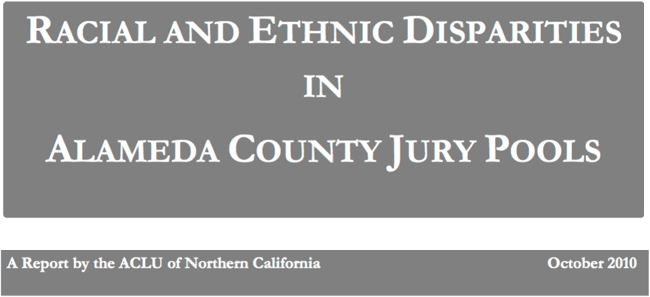

## Jury Panels

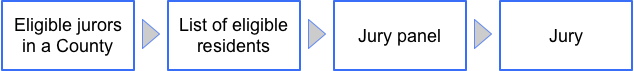

Section 197 of California's Code of Civil Procedure says, 
> "All persons selected for jury service shall be selected at random, from a source or sources inclusive of a representative cross section of the population of the area served by the court."

### ACLU study:
* ACLU studied the ethnic composition of jury panels in 11 felony trials in Alameda county between 2009 and 2010.
* Total number of people reporting for jury duty: 1453
* Compared to demographics of the county

In [ ]:
jury = bpd.DataFrame().assign(
    Ethnicity=['Asian', 'Black', 'Latino', 'White', 'Other'],
    Eligible=[0.15, 0.18, 0.12, 0.54, 0.01],
    Panels=[0.26, 0.08, 0.08, 0.54, 0.04]
)
jury

### Are the differences in representation meaningful?
* Model: The people on the jury panels were selected at random from the eligible population
    - Alternative viewpoint: no, they weren't.
* Observed: empirical distribution of panels
* Statistic: ???
    - How do we deal with multiple categories?

In [ ]:
jury.plot(kind='barh', x='Ethnicity')

### A new statistic: Distance between distributions
* People on the panels are of multiple ethnicities
* Distribution of ethnicities is categorical

* To see whether the the distribution of ethnicities of the panels is close to that of the eligible jurors, we have to measure the distance between two categorical distributions



### Statistic: Total Variation Distance
* Consider the absolute differences for each value.
* Sum all these differences (and divide by 2)

In [ ]:
with_diffs = jury.assign(
    Difference=(jury.get('Panels') - jury.get('Eligible')),
)

with_abs_diffs = with_diffs.assign(
    AbsoluteDifference=np.abs(with_diffs.get('Difference'))
)

with_abs_diffs

### Statistic: Total Variation Distance
* Consider the absolute differences for each value.
* Sum all these differences (and divide by 2)

In [ ]:
with_abs_diffs.get('AbsoluteDifference').sum() / 2

### Total Variation Distance
* What is the TVD between "all eligible" and the observed panels?
    - is this number large?

In [ ]:
#:
def total_variation_distance(dist1, dist2):
    '''Given two empirical distributions, 
    both sorted with same categories, calculates the TVD'''
    return np.abs((dist1 - dist2)).sum() / 2

In [ ]:
# Apply it to the Eligible and observed panel distributions
total_variation_distance(jury.get('Eligible'), jury.get('Panels'))

### Simulate drawing jury panels
* Model: Draw a random panel from "eligible" distribution
* Statistic: TVD between random panel and eligible
* Repeat and compare to observed statistic!

In [ ]:
#:
eligible = jury.get('Eligible')
sample_distribution = np.random.multinomial(1453, eligible) / 1453
panels_and_sample = jury.assign(RandomSample=sample_distribution)

In [ ]:
panels_and_sample

In [ ]:
panels_and_sample.plot(kind='barh', x='Ethnicity')

In [ ]:
total_variation_distance(panels_and_sample.get('RandomSample'), eligible)

### Put together the simulation

In [ ]:
tvds = np.array([])

for i in np.arange(10000):
    sample_distribution = np.random.multinomial(1453, eligible) / 1453
    new_tvd = total_variation_distance(sample_distribution, eligible)
    tvds = np.append(tvds, new_tvd)

In [ ]:
observed_tvd = total_variation_distance(jury.get('Panels'), eligible)

bpd.DataFrame().assign(TVD=tvds).plot(kind='hist', density=True, bins=20)
plt.scatter(observed_tvd, 0, color='red', s=30);

### Are the jury panels representative?
* Likely not! The random samples are not like the observed panels.
* This doesn't say *why* the distributions are different!
    - Juries drawn from voter rolls and DMV.
    - The county rarely follows up on failures to report.
    - Building the jury table is complicated! (see book)

### Summary of the method

To assess whether a sample was drawn randomly from a known categorical distribution:
* Use TVD as the statistic because it measures the distance between categorical distributions
* Sample at random from the population and compute the TVD from the random sample; repeat numerous times
* Compare:
    - Empirical distribution of simulated TVDs
    - Actual TVD from the sample in the study


# Decisions and Uncertainty

## Incomplete Information

* We try to choose between two views of the world, based on data in a sample.
* It's not always clear whether the data are consistent with one view or the other (unlike examples above).
* Random samples can turn out quite extreme. It is unlikely, but possible.


## Testing Hypotheses
* A test chooses between two views of how data were generated
* The views are called **hypotheses**
* The test picks the hypothesis that is better supported by the observed data
    - What is the probability that data was generated in this way?


## Null and Alternative
* The method only works if we can simulate data under one of the hypotheses.
* **Null hypothesis**
    - A well defined chance model about how the data were generated
    - We can simulate data under the assumptions of this model – “under the null hypothesis”
* **Alternative hypothesis**
    - A different view about the origin of the data

## Test Statistic
* The statistic that we choose to simulate, to decide between the two hypotheses

Questions before choosing the statistic:
* What values of the statistic will make us lean towards the null hypothesis?
* What values will make us lean towards the alternative?
    - Preferably, the answer should be just “high”. Try to avoid “both high and low”.


## Prediction Under the Null Hypothesis
* Simulate the test statistic under the null hypothesis; draw the histogram of the simulated values
* This displays the **empirical distribution of the statistic under the null hypothesis**
* It is a prediction about the statistic, made by the null hypothesis 
    - It shows all the likely values of the statistic
    - Also how likely they are (if the null hypothesis is true)
* The probabilities are approximate, because we can’t generate all the possible random samples


## Conclusion of the Test
Resolve choice between null and alternative hypotheses
* Compare the **observed test statistic** and its empirical distribution under the null hypothesis
* If the observed value is **not consistent** with the distribution, then the test favors the alternative – “rejects the null hypothesis”

Whether a value is consistent with a distribution:
* A visualization may be sufficient
* If not, there are conventions about “consistency”


## Performing a Test

### The Problem

* Large Statistics class divided into 12 discussion sections
* TAs lead the sections

* After the midterm, students in Section 3 notice that the average score in their section is lower than in others.




### The TA's Defense

GSI’s position (Null Hypothesis):
* It's chance. If students were divided into sections randomly, we'd probably see at least one section with a score this low.

Alternative:
* No, the average score is too low. Randomness is not the only reason for the low scores.


In [ ]:
scores = bpd.read_csv('scores_by_section.csv')
scores

In [ ]:
scores.groupby('Section').count()

In [ ]:
# Calculate the average midterm score per section
scores.groupby('Section').mean()

### What are the observed characteristics of section 3?
* Size of section? (`section_size`)
* Average of section? (`observed_avg`)

In [ ]:
#:
section_size = scores.groupby('Section').count().get('Midterm').loc[3]
observed_avg = scores.groupby('Section').mean().get('Midterm').loc[3]
print(section_size, observed_avg, sep='\n')

### Testing the null hypothesis
* Model: Sample uniformly (w/o replacement) 27 students from the class.
* Statistic: Calculate the average midterm score of "random" section.


In [ ]:
averages = np.array([])

for i in np.arange(10000):
    random_sample = scores.sample(int(section_size), replace=False)
    new_average = random_sample.get('Midterm').mean()
    averages = np.append(averages, new_average)

In [ ]:
bpd.DataFrame().assign(RandomSampleAverage=averages).plot(kind='hist', bins=25)
plt.scatter(observed_avg, 0, color = 'red', s=40, zorder=10);

## The Verdict?
* Not as obvious as previous examples!
* Need a concept to capture the uncertainty of the conclusion.

### Question
* What is the probability that under the Null Hypothesis, a result *at least* as extreme as our observation holds?
* This quantity is called a **p-value**

In [ ]:
#:
np.count_nonzero(averages <= observed_avg) / 10000

In [ ]:
bpd.DataFrame().assign(RandomSampleAverage=averages).plot(kind='hist', bins=25)
plt.scatter(observed_avg, 0, color = 'red', s=40, zorder=10);
plt.axvline(observed_avg, color='gold')

# Statistical Significance

## Definition of the P-value

Formal name: **observed significance level**

The P-value is the chance, under the null hypothesis, that the test statistic is equal to the value that was observed in the data or is even further in the direction of the alternative.

## Conventions About Inconsistency

* **“Inconsistent”**: The test statistic is in the tail of the empirical distribution under the null hypothesis

* **“In the tail,” first convention**:
    - The area in the tail is less than 5%
    - The result is “statistically significant”

* **“In the tail,” second convention**:
    - The area in the tail is less than 1%
    - The result is “highly statistically significant”


## An Error Probability

The cutoff for the P-value is an error probability.

* If:
    - your cutoff is 5%
    - and the null hypothesis happens to be true

* then there is about a 5% chance that your test will reject the null hypothesis.
